### Imports

In [1]:
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from transformer import SpaceTimeFormer

### Artificial Time Series

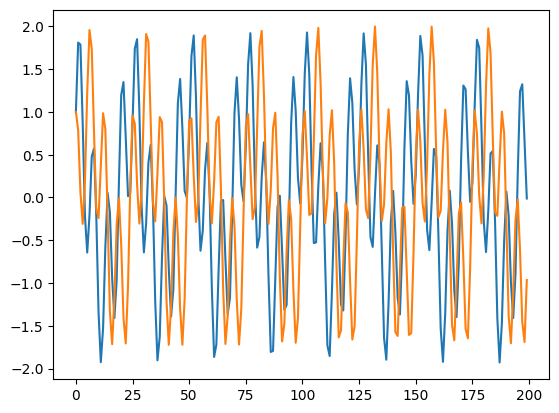

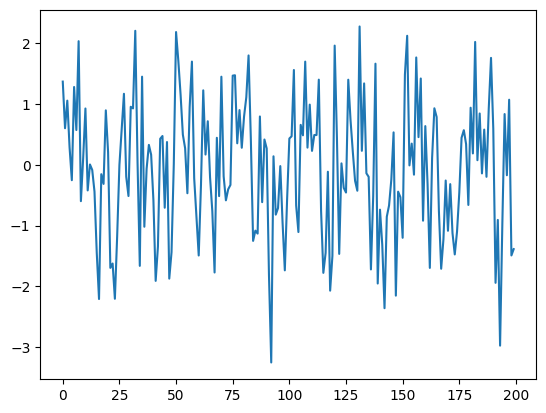

In [2]:
sequence_souce = np.zeros((2,200))
sequence_target = np.zeros((1,200))
sequence_souce[0,:] = np.sin(np.arange(0,200,1))+np.cos(np.arange(0,50,0.25))
sequence_souce[1,:] = np.cos(np.arange(0,200,1))+np.sin(np.arange(0,50,0.25))
sequence_target[0,:] = 0.3*sequence_souce[0,:]+0.7*sequence_souce[1,:]+np.random.normal(0,0.8,200)
plt.plot(sequence_souce[0,:])
plt.plot(sequence_souce[1,:])
plt.show()
plt.plot(sequence_target[0,:])
plt.show()

### Test Data Loader

In [3]:
from utils import load_src_trg

In [4]:
data_iter = load_src_trg(sequence_souce, sequence_target, 5, 2, 2)

In [5]:
for src, trg, trg_y in data_iter:
    print(np.shape(src))
    print(src)
    print(trg)
    print(trg_y)
    break

torch.Size([2, 2, 5])
tensor([[[ 1.0000,  1.8104,  1.7869,  0.8728, -0.2165],
         [ 1.0000,  0.7877,  0.0633, -0.3084,  0.1878]],

        [[ 1.8104,  1.7869,  0.8728, -0.2165, -0.6436],
         [ 0.7877,  0.0633, -0.3084,  0.1878,  1.2326]]], dtype=torch.float64)
tensor([[[ 0.5994,  1.0532,  0.2870, -0.2550,  1.2777,  0.5697]],

        [[ 1.0532,  0.2870, -0.2550,  1.2777,  0.5697,  2.0305]]],
       dtype=torch.float64)
tensor([[[ 0.5994,  1.0532,  0.2870, -0.2550,  1.2777,  0.5697]],

        [[ 1.0532,  0.2870, -0.2550,  1.2777,  0.5697,  2.0305]]],
       dtype=torch.float64)


### Test Training

In [6]:
split = 0.8
pred_window = 2
seq_length = 10
sequence_source_train = sequence_souce[:, :int(np.shape(sequence_souce)[1]*split)]
sequence_source_test = sequence_souce[:, int(np.shape(sequence_souce)[1]*split):]
sequence_target_train = sequence_target[:, :int(np.shape(sequence_target)[1]*split)]
sequence_target_test = sequence_target[:, int(np.shape(sequence_target)[1]*split):]

In [25]:
model = SpaceTimeFormer(pred_offset = pred_window,
                        input_size = 2,
                        output_size = 1,
                        seq_length = seq_length,
                        embedding_size_time = 10,
                        embedding_size_variable = 10)

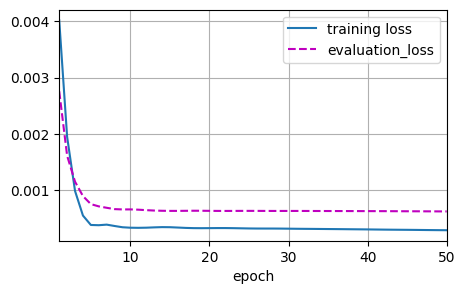

In [26]:
model.start_training(source=sequence_source_train,
                     target=sequence_target_train,
                     loss=nn.MSELoss(),
                     metric=nn.MSELoss(),
                     epochs=50,
                     batch_size=64,
                     learning_rate=1e-4,
                     standardize=True,
                     verbose=False,
                     plot=True)

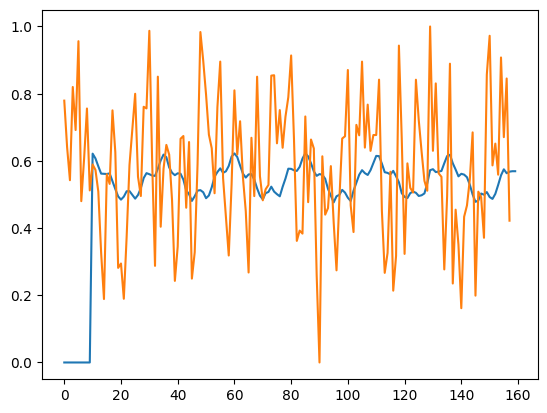

In [27]:
standardize = True
source = sequence_source_train
target = sequence_target_train

if standardize:
    scaler = preprocessing.MinMaxScaler().fit(source.transpose())
    source = scaler.transform(source.transpose()).transpose()
    scaler = preprocessing.MinMaxScaler().fit(target.transpose())
    target = scaler.transform(target.transpose()).transpose()

l = np.shape(sequence_source_train)[1]
y_hat = np.zeros((1,l))
y = target[:, 2:]

src_idx_1, src_idx_2 = 0, 0
trg_idx_1, trg_idx_2 = 1, 1

while trg_idx_2 < l:
    src_idx_2 = src_idx_1 + seq_length
    trg_idx_2 = trg_idx_1 + seq_length + pred_window - 1
    
    src = source[:, src_idx_1:src_idx_2]
    trg_stub = target[:, trg_idx_1:trg_idx_2-pred_window]
    y_hat[0, trg_idx_2-pred_window:trg_idx_2] = model.predict(src, trg_stub, False)
    
    src_idx_1 += 1
    trg_idx_1 += 1

plt.plot(y_hat[0,:])
plt.plot(y[0,:])
plt.show()

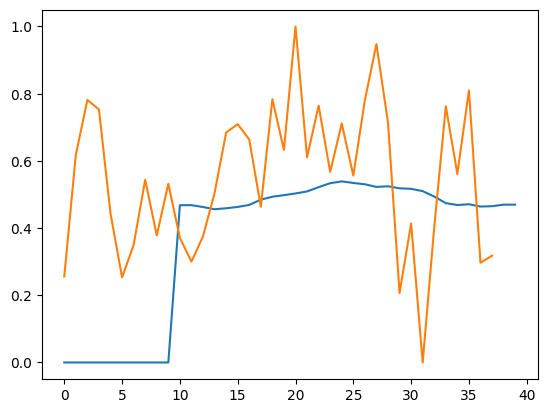

In [21]:
source = sequence_source_test
target = sequence_target_test

if standardize:
    scaler = preprocessing.MinMaxScaler().fit(source.transpose())
    source = scaler.transform(source.transpose()).transpose()
    scaler = preprocessing.MinMaxScaler().fit(target.transpose())
    target = scaler.transform(target.transpose()).transpose()

l = np.shape(source)[1]
y_hat = np.zeros((1,l))
y = target[:, 2:]

src_idx_1, src_idx_2 = 0, 0
trg_idx_1, trg_idx_2 = 1, 1

while trg_idx_2 < l:
    src_idx_2 = src_idx_1 + seq_length
    trg_idx_2 = trg_idx_1 + seq_length + pred_window - 1
    
    src = source[:, src_idx_1:src_idx_2]
    trg_stub = target[:, trg_idx_1:trg_idx_2-pred_window]
    y_hat[0, trg_idx_2-pred_window:trg_idx_2] = model.predict(src, trg_stub, False)
    
    src_idx_1 += 1
    trg_idx_1 += 1

plt.plot(y_hat[0,:])
plt.plot(y[0,:])
plt.show()

In [21]:
src

array([[-0.4475128 , -1.5329563 , -1.92096984, -1.35079934, -0.3924065 ,
         0.08039587, -0.30713241, -1.08985199, -1.3971586 , -0.76279955],
       [-0.23051615, -0.15482848,  0.54063341,  1.02548058,  0.64515279,
        -0.46430006, -1.48801961, -1.66875975, -0.99165764, -0.18849088]])

In [22]:
trg_stub

array([[ 0.0443958 , -0.056875  ,  0.58461918, -0.24173572,  0.51523094,
        -2.37079875, -2.61609931, -0.36503597,  0.58509168]])

In [24]:
sequence_target_test[0,1:10]

array([ 0.0443958 , -0.056875  ,  0.58461918, -0.24173572,  0.51523094,
       -2.37079875, -2.61609931, -0.36503597,  0.58509168])

In [25]:
trg_y

array([[ 0.0443958 , -0.056875  ,  0.58461918, -0.24173572,  0.51523094,
        -2.37079875, -2.61609931, -0.36503597,  0.58509168,  0.12277014,
        -0.70740609]])

In [27]:
sequence_target_test[0,1:12]

array([ 0.0443958 , -0.056875  ,  0.58461918, -0.24173572,  0.51523094,
       -2.37079875, -2.61609931, -0.36503597,  0.58509168,  0.12277014,
       -0.70740609])

In [10]:
import torch

test = torch.tensor([[[-0.5669],
         [-0.4162],
         [-0.5322],
         [-0.4995],
         [-0.4603],
         [-0.5197],
         [-0.4310],
         [-0.4902],
         [-0.5116],
         [-0.4543],
         [-0.4352]]])

In [11]:
test.size()

torch.Size([1, 11, 1])